In [1]:
import csv
import pandas as pd 
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import networkx as nx
import pdb
import collections
from node2vec import Node2Vec
from networkx.algorithms import community as nxcomm

In [2]:
edges = pd.read_csv('../data/twitch_gamers/large_twitch_edges.csv', header=0)
edges.columns = ['source', 'target']

In [3]:
G = nx.from_pandas_edgelist(edges, source='source', target='target', create_using=nx.Graph())

print("Number of nodes:", nx.number_of_nodes(G))
print("Number of edges:", nx.number_of_edges(G))
print("Density:", nx.density(G))
#print("Average Shortest Path Length:", nx.average_shortest_path_length(G))  ## too long
#print("Diameter:", nx.diameter(G))  ## too long

Number of nodes: 168114
Number of edges: 6797557
Density: 0.00048103610439398153


In [4]:
degree_dict = dict(G.degree)
selected_nodes = []
for i in degree_dict:
    if degree_dict[i] >= 500:
        selected_nodes.append(i)
        
edges_filtered = edges[edges["source"].isin(selected_nodes)]
edges_filtered = edges[edges["target"].isin(selected_nodes)]

In [5]:
G = nx.from_pandas_edgelist(edges_filtered, source='source', target='target', create_using=nx.Graph())

print("Number of nodes:", nx.number_of_nodes(G))
print("Number of edges:", nx.number_of_edges(G))
print("Density:", nx.density(G))
#print("Average Shortest Path Length:", nx.average_shortest_path_length(G))  ## too long
print("Diameter:", nx.diameter(G))

Number of nodes: 37281
Number of edges: 567609
Density: 0.0008168001558284934
Diameter: 6


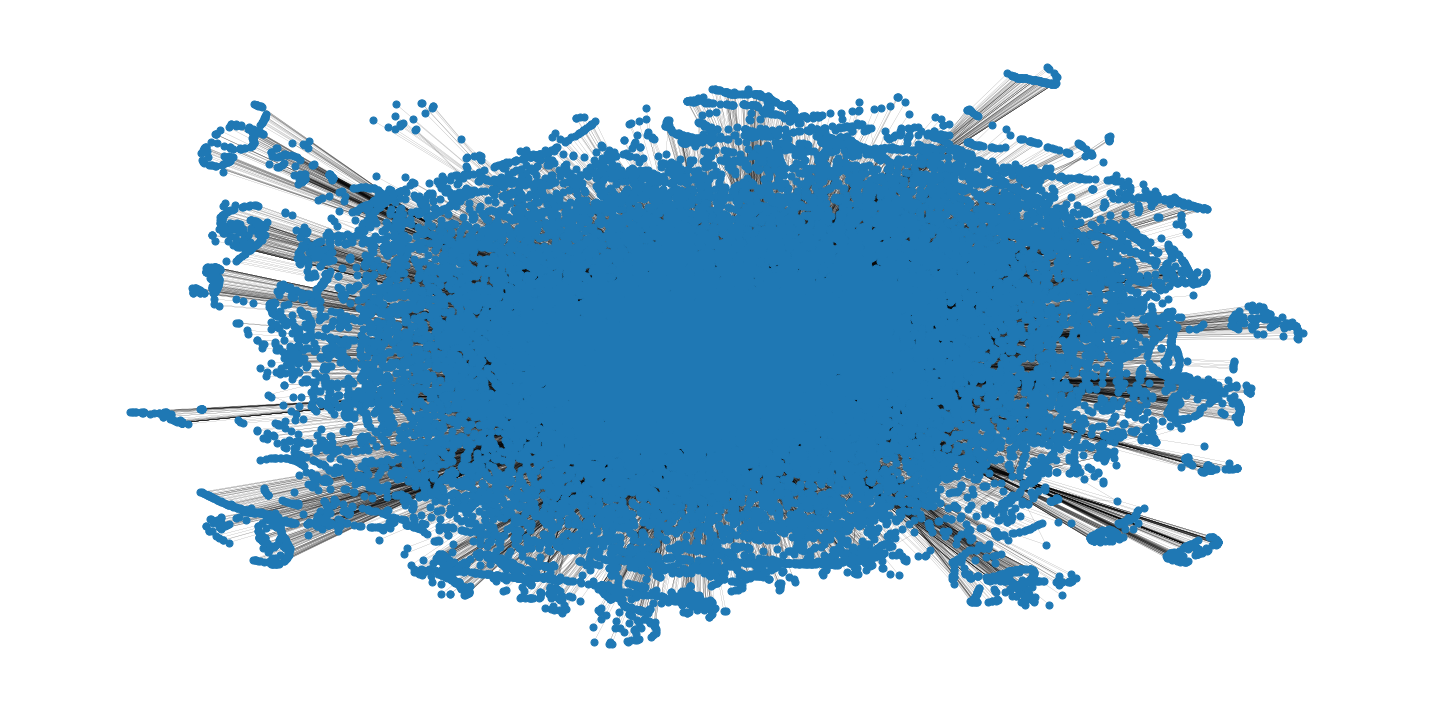

In [6]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed = 42)
# nodes 
nx.draw_networkx_nodes(G, pos, node_size=50)
# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.1)

plt.axis("off")
plt.tight_layout()
plt.show()

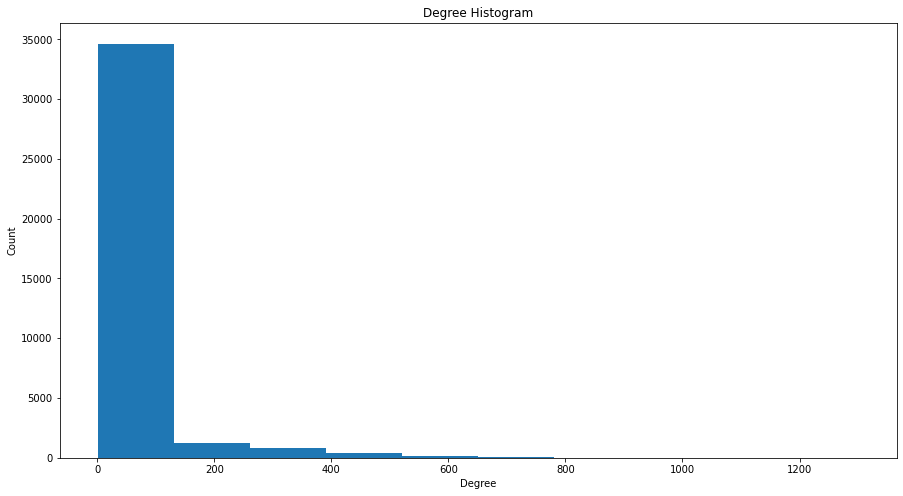

In [27]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)

deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(15, 8))
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.hist(degree_sequence)
plt.show()

In [29]:
n2v = Node2Vec(G, dimensions=20, walk_length=10, num_walks=100, p = 1, q = 1, weight_key = None, workers=4) 
model = n2v.fit(window=5)

Computing transition probabilities: 100%|██████████| 37281/37281 [22:22<00:00, 27.77it/s] 
C:\Users\Peter\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [31]:
model.wv.save_word2vec_format('embeddings.txt')
embeddings = pd.read_csv('embeddings.txt', sep=' ', skiprows=1, header=None, index_col = 0)

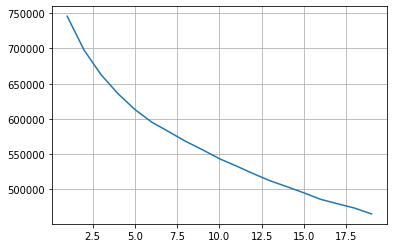

In [32]:
from sklearn import cluster as clu
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
x_values = []
y_values = []

for i in range(1, 20):
  pipe1 = pip.Pipeline([
          ("scaler", pre.StandardScaler()),
          ("kmeans", clu.KMeans(n_clusters=i, random_state=42))
  ])
  pipe1.fit(embeddings)
  x_values.append(i)
  y_values.append(pipe1.named_steps["kmeans"].inertia_)

plt.plot(x_values, y_values)
plt.grid(True)
plt.show()

In [33]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 6).fit(embeddings)
comms = dict(zip(embeddings.index, km.labels_))
comm_colors = [comms.get(node) for node in G.nodes()]

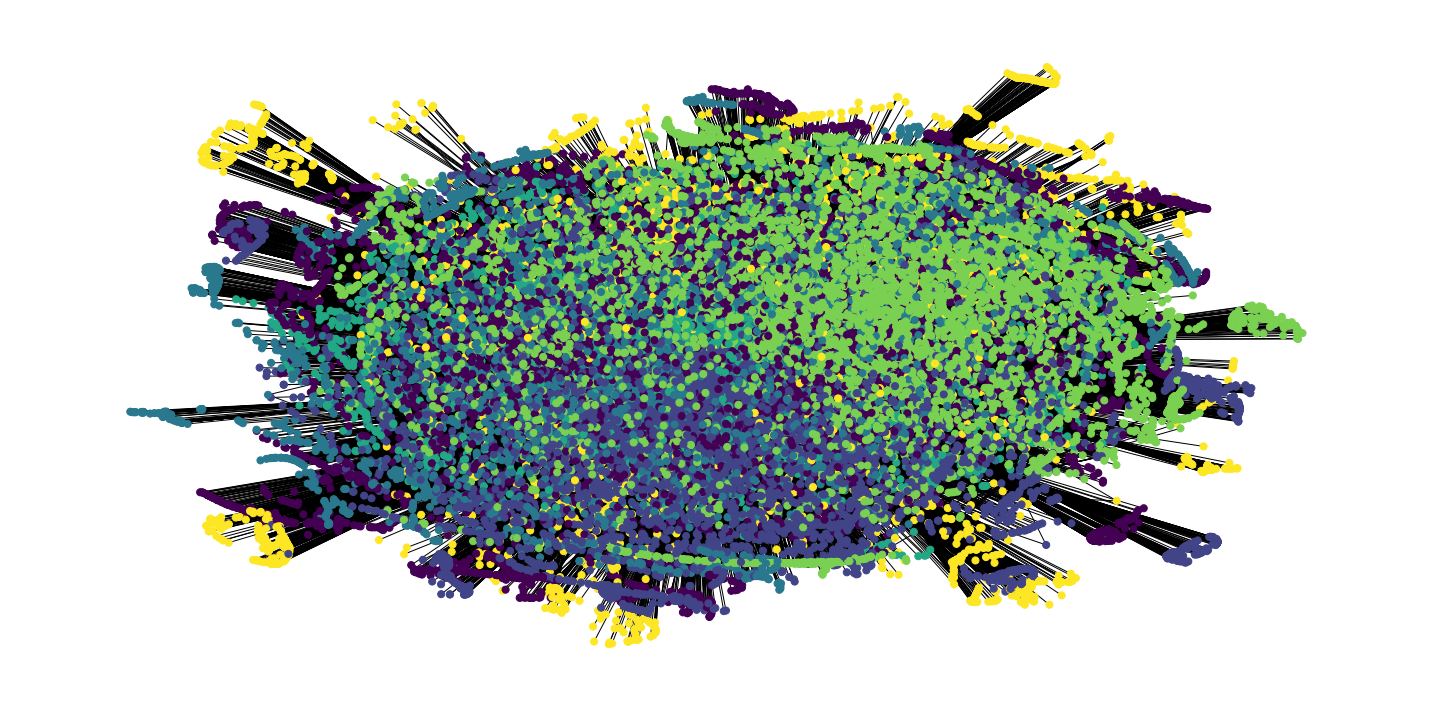

In [36]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed = 42) 
# nodes
nx.draw_networkx_nodes(G, pos, node_color=comm_colors, node_size=50)
# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges())

plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
def community_layout(g, partition):

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def visualize(g, partition_g):
    pos = community_layout(g, partition_g)
    plt.figure(figsize=(15, 10))
    nx.draw(g, pos, node_color=list(partition_g.values())); plt.show()
    return

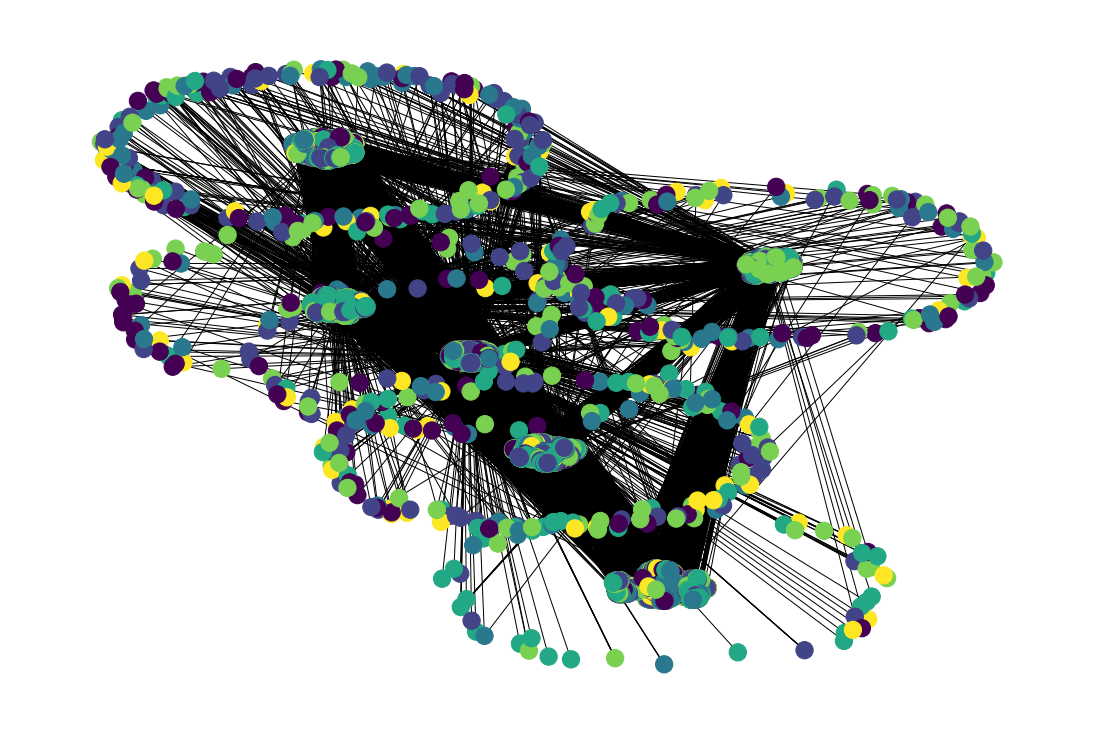

In [38]:
visualize(G,comms)